# 1️. Business Understanding

## Business Background

Bike-sharing systems rely on efficient bike distribution and station capacity planning to maintain service quality and reduce shortages during peak demand.

The Transport for London (TfL) Cycle Hire system operates across hundreds of stations in London. However, not all stations exhibit the same demand patterns. Some stations experience strong commuter-driven peaks, while others show leisure-based or low-frequency usage.

Without understanding station-level behavioral differences, operators may allocate resources inefficiently, leading to:

- Bike shortages during peak hours
- Idle capacity at low-demand stations
- Increased redistribution costs
- Reduced user satisfaction

This project focuses on station behavioral segmentation to support data-driven operational decision-making.


---

## Key Analytical Questions

1. What are the temporal demand patterns across London bike stations?
2. Do stations exhibit distinct behavioral usage patterns?
3. Can stations be grouped into meaningful operational segments?
4. What operational strategies can be applied to each station segment?
5. Are the differences between station groups statistically significant?


---

## Expected Business Impact

By segmenting stations based on usage behavior, operators can:

- Optimize bike redistribution schedules
- Improve peak-hour availability
- Reduce idle capacity at low-demand stations
- Enhance service reliability
- Support capacity planning decisions

The ultimate objective is to improve operational efficiency and maximize resource utilization across the bike-sharing network.


---

# 2️. Data Overview

## Data Source

The dataset was obtained from Kaggle:

London Bike Share Usage Dataset  
https://www.kaggle.com/datasets/kalacheva/london-bike-share-usage-dataset

The original data source is the official Transport for London (TfL) Open Data Portal:
https://tfl.gov.uk/info-for/open-data-users/our-open-data

The data contains detailed trip-level records from the TfL Cycle Hire system.


---

## Time Range

The dataset covers:

August 1, 2023 – August 31, 2023

This provides a complete one-month snapshot of bike-sharing activity in London.


---

## Number of Records

- Total trip records: 776,527  
- Data granularity: Trip-level  


---

## Number of Stations

- Approximately 800 unique stations  
- Each station can act as both origin and destination  


---

## Field Description

| Column Name | Description |
|-------------|-------------|
| Trip ID | Unique identifier for each bike trip |
| Start Date | Trip start timestamp |
| Start Station Number | Unique ID of origin station |
| Start Station | Name of origin station |
| End Date | Trip end timestamp |
| End Station Number | Unique ID of destination station |
| End Station | Name of destination station |
| Bike Number | Unique identifier of the bike |
| Bike Model | Model type of the bike |
| Total Duration | Trip duration (HH:MM:SS format) |
| Total Duration (ms) | Trip duration in milliseconds |


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.colors as mcolors

plt.rcParams['font.sans-serif']=['simhei']
plt.rcParams['axes.unicode_minus']=False


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# 3️. Data Cleaning & Preprocessing

In [26]:
data=pd.read_csv('./LondonBikeJourneyAug2023.csv')
data.head()

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,132825189,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663
1,132825190,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128
2,132825191,8/1/2023 0:00,983,"Euston Road, Euston",8/1/2023 0:11,3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395
3,132825192,8/1/2023 0:01,3479,"Old Brompton Road, South Kensington",8/1/2023 0:12,1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059
4,132825193,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",8/1/2023 0:17,200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786


### Dataset Size

776,527 trip-level records across 11 columns.  
Sufficient volume for robust station-level analysis.

In [27]:
# Check dataset dimensions
num_rows, num_columns = data.shape

print(f"Total number of trip records: {num_rows:,}")
print(f"Total number of columns: {num_columns}")


Total number of trip records: 776,527
Total number of columns: 11


### Missing Value Check

No missing values detected across all columns.  
Dataset is complete and ready for aggregation and segmentation.


In [28]:
# Check for missing values in each column
missing_values = data.isna().sum()

print("Missing values by column:")
print(missing_values)


Missing values by column:
Number                  0
Start date              0
Start station number    0
Start station           0
End date                0
End station number      0
End station             0
Bike number             0
Bike model              0
Total duration          0
Total duration (ms)     0
dtype: int64


In [29]:
# Check dataset structure and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776527 entries, 0 to 776526
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Number                776527 non-null  int64 
 1   Start date            776527 non-null  object
 2   Start station number  776527 non-null  int64 
 3   Start station         776527 non-null  object
 4   End date              776527 non-null  object
 5   End station number    776527 non-null  int64 
 6   End station           776527 non-null  object
 7   Bike number           776527 non-null  int64 
 8   Bike model            776527 non-null  object
 9   Total duration        776527 non-null  object
 10  Total duration (ms)   776527 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 65.2+ MB


In [30]:
# Check for duplicate records
data.duplicated().sum()

0

### Data Type Conversion

The timestamp columns were originally stored as object types and converted to datetime format to enable time-based feature engineering.

Trip duration in milliseconds is retained as a numeric variable for aggregation and clustering purposes.

Proper data typing ensures:

- Accurate time-based aggregation
- Reliable station-level feature construction
- Compatibility with clustering algorithms


In [9]:
# Convert timestamp columns to datetime format
data['Start date'] = pd.to_datetime(data['Start date'])
data['End date'] = pd.to_datetime(data['End date'])

# Convert trip duration to numeric (milliseconds already numeric)
data['Total duration (ms)'] = pd.to_numeric(data['Total duration (ms)'], errors='coerce')
data.head()

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,132825189,2023-08-01 00:00:00,1190,"Kennington Lane Rail Bridge, Vauxhall",2023-08-01 00:17:00,1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663
1,132825190,2023-08-01 00:00:00,1190,"Kennington Lane Rail Bridge, Vauxhall",2023-08-01 00:17:00,1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128
2,132825191,2023-08-01 00:00:00,983,"Euston Road, Euston",2023-08-01 00:11:00,3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395
3,132825192,2023-08-01 00:01:00,3479,"Old Brompton Road, South Kensington",2023-08-01 00:12:00,1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059
4,132825193,2023-08-01 00:01:00,1219,"Lower Marsh, Waterloo",2023-08-01 00:17:00,200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786


### Time Range Verification

Trip start dates range from August 1 to August 31, 2023.  
Analysis will be based on trip start time to ensure temporal consistency.


In [31]:
# Check dataset time coverage
start_min = data['Start date'].min()
start_max = data['Start date'].max()
end_min = data['End date'].min()
end_max = data['End date'].max()

print(f"Start date range: {start_min} → {start_max}")
print(f"End date range: {end_min} → {end_max}")


Start date range: 8/1/2023 0:00 → 8/9/2023 9:59
End date range: 11/9/2023 20:19 → 9/9/2023 17:16


### Column Removal

End timestamp removed as demand analysis is based on trip start time.


In [32]:
# Remove end timestamp (analysis based on start time)
data.drop(columns=['End date'], inplace=True)
data.head()

,Number,Start date,Start station number,Start station,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,132825189,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663
1,132825190,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128
2,132825191,8/1/2023 0:00,983,"Euston Road, Euston",3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395
3,132825192,8/1/2023 0:01,3479,"Old Brompton Road, South Kensington",1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059
4,132825193,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786


### Station Consistency Check

Start and end station counts are compared to ensure network consistency.
Minor discrepancies will be evaluated and cleaned if necessary.


In [33]:
# Check number of unique start and end stations
start_station_count = data['Start station'].nunique()
end_station_count = data['End station'].nunique()

print(f"Unique start stations: {start_station_count}")
print(f"Unique end stations: {end_station_count}")


Unique start stations: 800
Unique end stations: 802


In [35]:
# Identify stations appearing only as end stations
start_set = set(data['Start station'].unique())
end_set = set(data['End station'].unique())

stations_only_end = end_set - start_set

# Remove those rare records
data = data[~data['Start station'].isin(stations_only_end)]
data = data[~data['End station'].isin(stations_only_end)]


Rare stations appearing only as destinations were removed to maintain station-level analytical consistency.


In [36]:
# Remove trips starting and ending at the same station
data = data[data['Start station'] != data['End station']]


Trips starting and ending at the same station were removed to avoid bias in flow-based analysis.


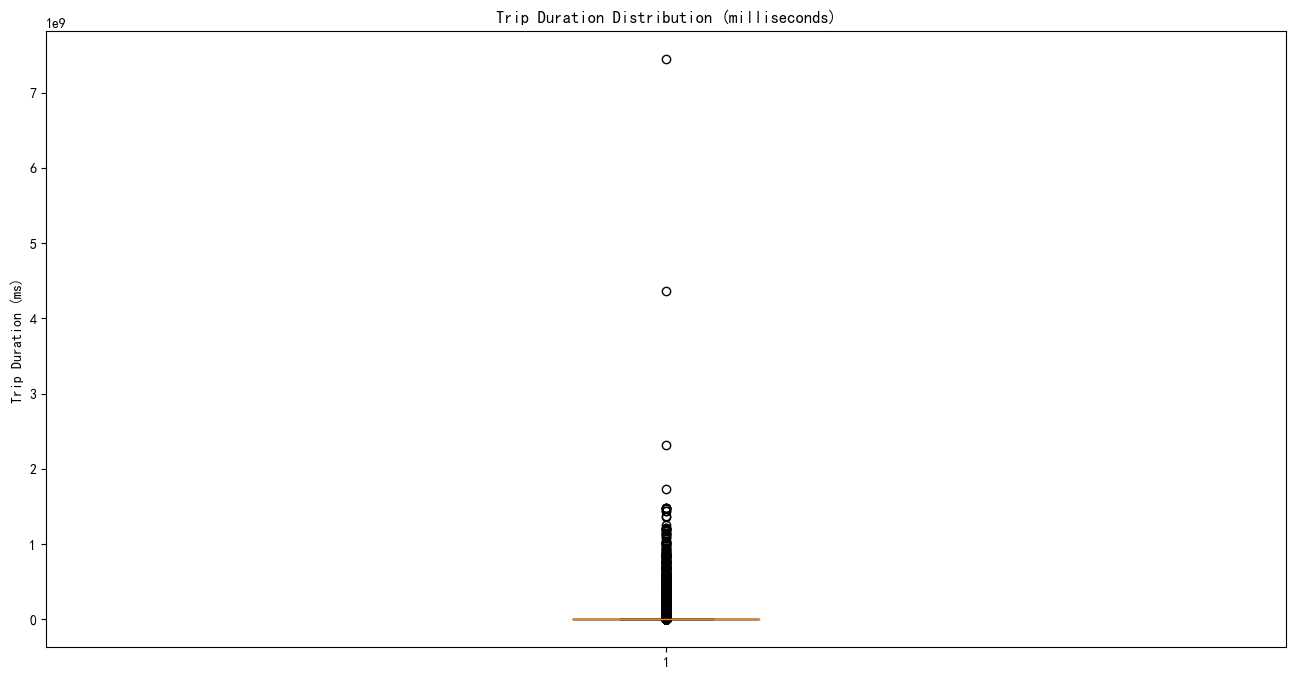

In [37]:
plt.figure(figsize=(16,8))
plt.boxplot(data['Total duration (ms)'])
plt.title('Trip Duration Distribution (milliseconds)')
plt.ylabel('Trip Duration (ms)')
plt.show()

### Duration Standardization

Trip duration converted to seconds for numerical analysis.
Milliseconds column removed after conversion.


In [38]:
# Convert duration to seconds using milliseconds column
data['Total duration (s)'] = data['Total duration (ms)'] / 1000

# Remove original milliseconds column
data.drop(columns=['Total duration (ms)'], inplace=True)
data.head()


,Number,Start date,Start station number,Start station,End station number,End station,Bike number,Bike model,Total duration,Total duration (s)
0,132825189,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006.663
1,132825190,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007.128
2,132825191,8/1/2023 0:00,983,"Euston Road, Euston",3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666.395
3,132825192,8/1/2023 0:01,3479,"Old Brompton Road, South Kensington",1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713.059
4,132825193,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963.786


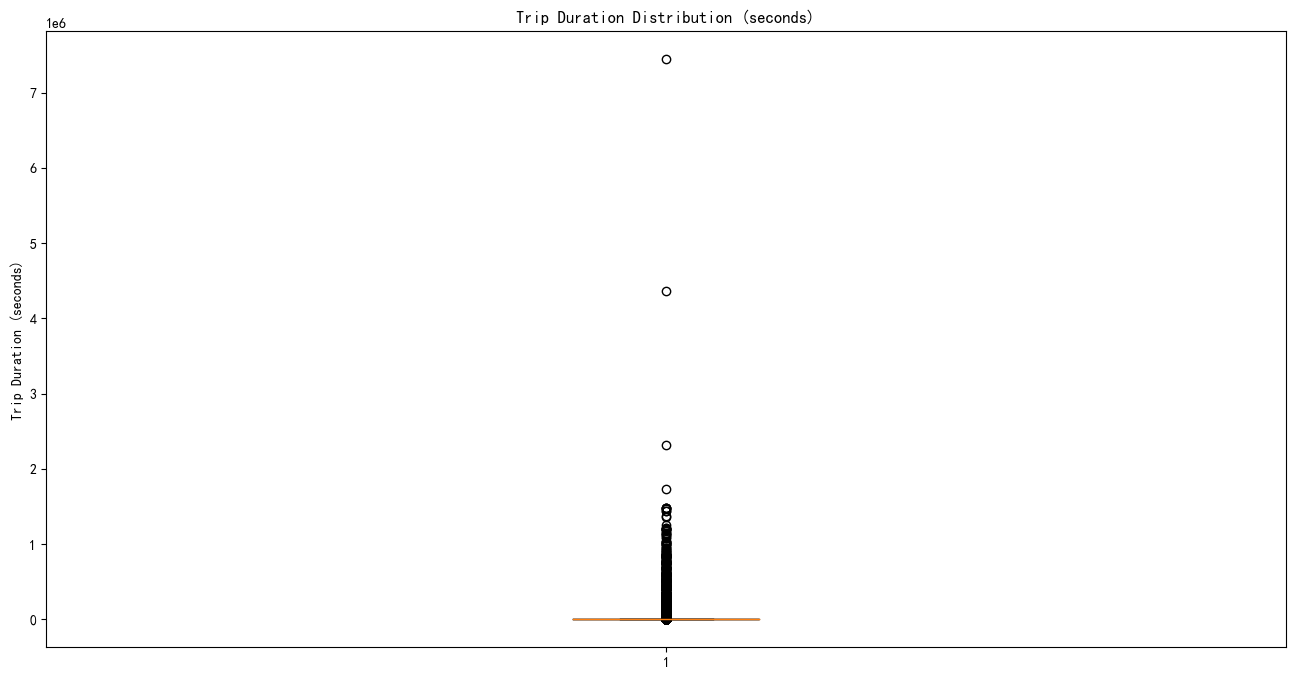

In [39]:
plt.figure(figsize=(16,8))
plt.boxplot(data['Total duration (s)'])
plt.title('Trip Duration Distribution (seconds)')
plt.ylabel('Trip Duration (seconds)')
plt.show()

The graph shows that there are still outliers, with over 80,000 seconds, which is about 22 hours. Normally, no one would ride a shared bike for that long. Here, we set an upper limit of 8 hours (8 hours equals 28,800 seconds) and a lower limit of 1 minute (if it is less than 1 minute, it can be judged as abnormal data, or the ride did not occur).

### Outlier Filtering

Trips shorter than 1 minute or longer than 8 hours were removed.

This ensures realistic behavioral representation and prevents extreme values from distorting station-level aggregation.


In [40]:
# Define reasonable trip duration bounds
min_duration = 60          # 1 minute
max_duration = 8 * 3600    # 8 hours

# Filter out extreme values
data = data[
    (data['Total duration (s)'] >= min_duration) &
    (data['Total duration (s)'] <= max_duration)
].copy()


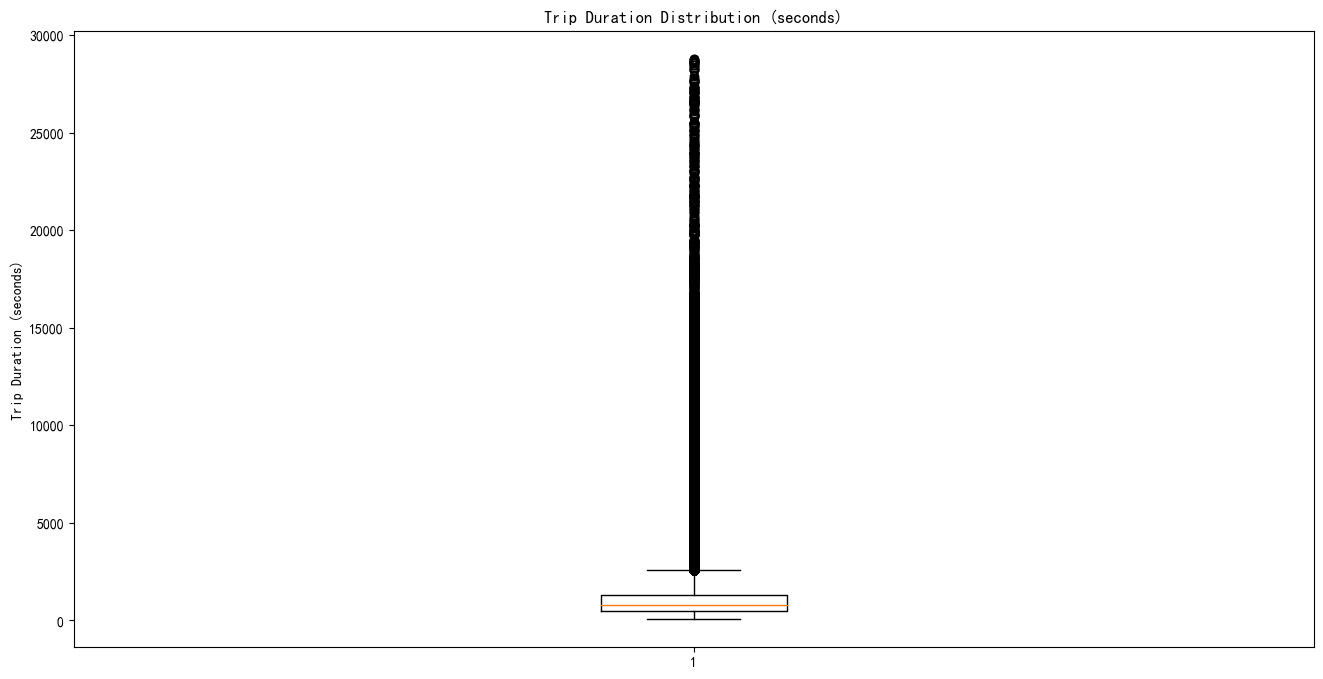

In [41]:
plt.figure(figsize=(16,8))
plt.boxplot(data['Total duration (s)'])
plt.title('Trip Duration Distribution (seconds)')
plt.ylabel('Trip Duration (seconds)')
plt.show()

### Time Feature Engineering

Extracted hour, weekday, and weekend indicators from trip start time.

These features enable peak-hour analysis and behavioral segmentation.


In [47]:
# Ensure datetime format
data['Start date'] = pd.to_datetime(data['Start date'], errors='raise')

# Feature engineering
data = data.assign(
    date = data['Start date'].dt.date,
    hour = data['Start date'].dt.hour,
    weekday = data['Start date'].dt.day_name(),
    is_weekend = data['Start date'].dt.weekday >= 5
)
data.head()

,Number,Start date,Start station number,Start station,End station number,End station,Bike number,Bike model,Total duration,Total duration (s),date,hour,weekday,is_weekend
0,132825189,2023-08-01 00:00:00,1190,"Kennington Lane Rail Bridge, Vauxhall",1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006.663,2023-08-01,0,Tuesday,False
1,132825190,2023-08-01 00:00:00,1190,"Kennington Lane Rail Bridge, Vauxhall",1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007.128,2023-08-01,0,Tuesday,False
2,132825191,2023-08-01 00:00:00,983,"Euston Road, Euston",3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666.395,2023-08-01,0,Tuesday,False
3,132825192,2023-08-01 00:01:00,3479,"Old Brompton Road, South Kensington",1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713.059,2023-08-01,0,Tuesday,False
4,132825193,2023-08-01 00:01:00,1219,"Lower Marsh, Waterloo",200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963.786,2023-08-01,0,Tuesday,False


# 4️. Exploratory Data Analysis (EDA)

### Descriptive Statistics Summary

- Total valid trips after cleaning: ~735,000  
- Unique stations: 800 (start and end)  
- Median trip duration: ~817 seconds (~13.6 minutes)  
- Mean trip duration: ~1,094 seconds (~18 minutes)  
- Typical usage hour (median): 15:00  
- Hour range: 0–23  

Trip duration distribution shows moderate right skew, 
indicating the presence of longer recreational rides alongside typical short urban trips.

Overall, the dataset reflects a high-volume, short-duration, commuter-oriented bike-sharing system.


In [48]:
# Summary statistics
data.describe(include='all')

,Number,Start date,Start station number,Start station,End station number,End station,Bike number,Bike model,Total duration,Total duration (s),date,hour,weekday,is_weekend
count,7.351230e+05,735123,7.351230e+05,735123,7.351230e+05,735123,735123.000000,735123,735123,735123.000000,735123,735123.000000,735123,735123
unique,NaN,NaN,NaN,800,NaN,800,NaN,2,9953,NaN,31,NaN,7,2
top,NaN,NaN,NaN,"Hyde Park Corner, Hyde Park",NaN,"Waterloo Station 3, Waterloo",NaN,CLASSIC,7m 48s,NaN,2023-08-09,NaN,Wednesday,False
freq,NaN,NaN,NaN,4448,NaN,4598,NaN,676962,658,NaN,30118,NaN,136536,588823
mean,1.332250e+08,2023-08-16 14:23:47.573262848,1.044177e+05,NaN,1.039949e+05,NaN,49712.427681,NaN,NaN,1094.231486,NaN,13.960415,NaN,NaN
min,1.328252e+08,2023-08-01 00:00:00,9.590000e+02,NaN,9.590000e+02,NaN,2.000000,NaN,NaN,60.059000,NaN,0.000000,NaN,NaN
25%,1.330243e+08,2023-08-09 09:09:00,1.129000e+03,NaN,1.124000e+03,NaN,50672.000000,NaN,NaN,481.999500,NaN,10.000000,NaN,NaN
50%,1.332250e+08,2023-08-16 16:10:00,3.468000e+03,NaN,3.465000e+03,NaN,54687.000000,NaN,NaN,817.443000,NaN,15.000000,NaN,NaN
75%,1.334254e+08,2023-08-23 18:44:00,2.001780e+05,NaN,2.001780e+05,NaN,58218.000000,NaN,NaN,1330.045000,NaN,18.000000,NaN,NaN
max,1.336251e+08,2023-08-31 23:59:00,1.100444e+06,NaN,1.100444e+06,NaN,61201.000000,NaN,NaN,28770.982000,NaN,23.000000,NaN,NaN


### Daily Demand Trend – Key Insights

- Ride volume and total duration move closely together, indicating consistent trip length patterns.
- Demand remains relatively stable throughout August, with no structural breaks.
- Noticeable dips occur on weekends, confirming weekday-dominant commuter usage.
- No abnormal spikes suggest stable system operation during the observation period.

Overall, August demand reflects a predictable, commuter-driven mobility pattern suitable for station-level segmentation and capacity optimization analysis.


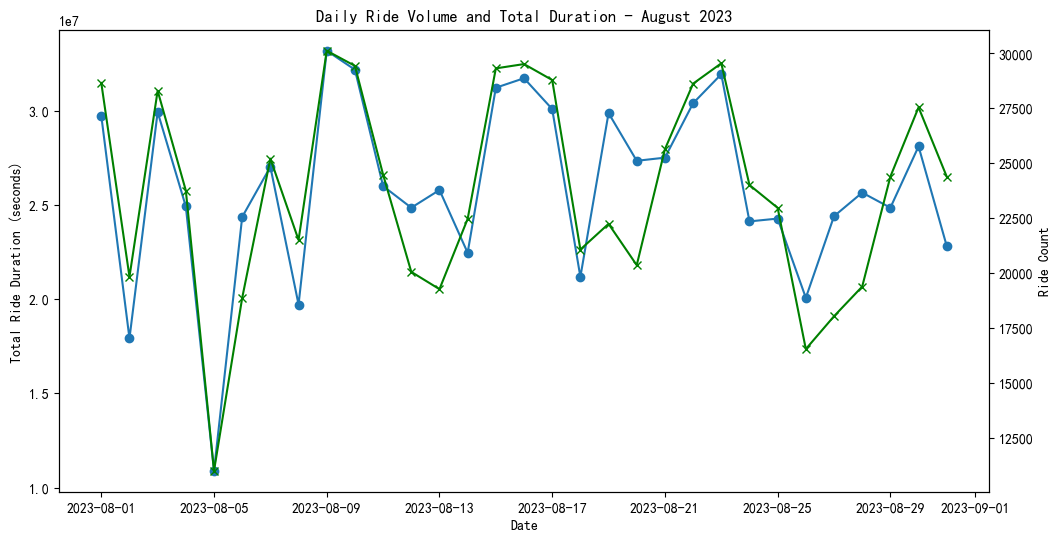

In [49]:
# Daily aggregation
daily_stats = (
    data.groupby('date')
        .agg(
            total_duration_sec=('Total duration (s)', 'sum'),
            ride_count=('Number', 'count')
        )
        .reset_index()
)


fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(daily_stats['date'], daily_stats['total_duration_sec'], marker='o')
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Ride Duration (seconds)")

ax2 = ax1.twinx()
ax2.plot(daily_stats['date'], daily_stats['ride_count'], color='green', marker='x')
ax2.set_ylabel("Ride Count")

plt.title("Daily Ride Volume and Total Duration - August 2023")
plt.show()


### Weekday vs Weekend Demand – Key Insights

- Ride activity peaks midweek (Tuesday–Thursday).
- Demand declines noticeably on weekends, especially Saturday.
- Total ride duration follows the same pattern as ride count.

The demand structure strongly indicates a commuter-oriented mobility system, 
with usage concentrated during working days rather than leisure periods.


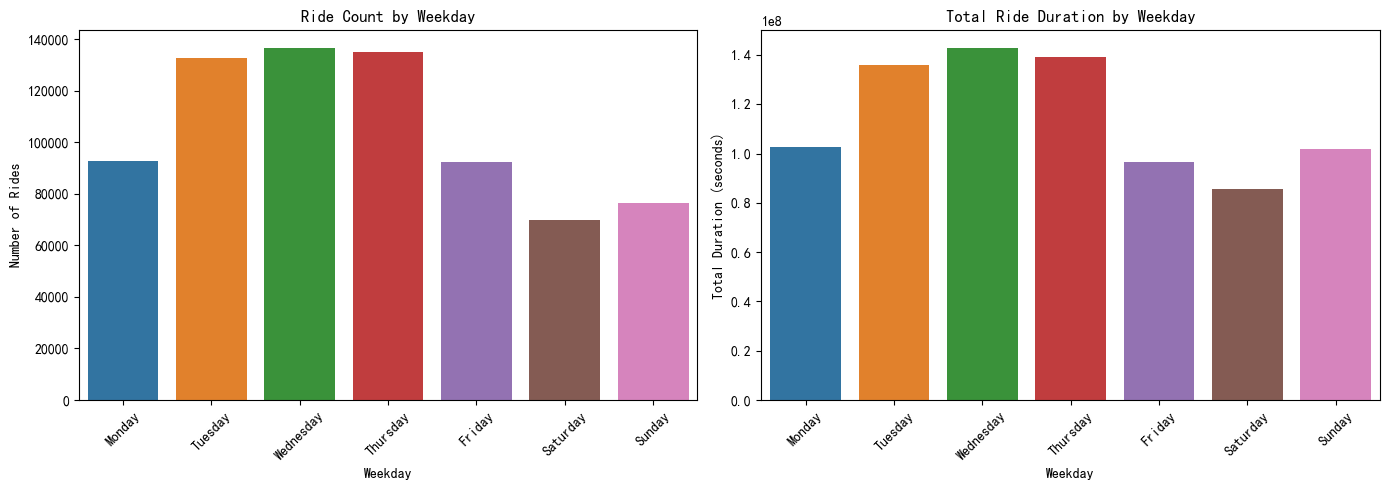

In [50]:

# Aggregate ride count by weekday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 
                 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_rides = data.groupby('weekday').size().reindex(weekday_order)

# Aggregate total duration by weekday
weekly_duration = (
    data.groupby('weekday')['Total duration (s)']
        .sum()
        .reindex(weekday_order)
)

plt.figure(figsize=(14,5))

# Ride count plot
plt.subplot(1,2,1)
sns.barplot(x=weekly_rides.index, y=weekly_rides.values)
plt.title("Ride Count by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)

# Total duration plot
plt.subplot(1,2,2)
sns.barplot(x=weekly_duration.index, y=weekly_duration.values)
plt.title("Total Ride Duration by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Total Duration (seconds)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Hourly Demand Pattern – Key Insights

- A clear bimodal distribution is observed.
- Morning peak: 7–9 AM  
- Evening peak: 5–6 PM  
- Lowest demand occurs between 12–5 AM.

This pattern strongly indicates commuter-driven mobility behavior, 
with rides concentrated during work start and end hours.

Peak-hour concentration suggests that station segmentation should incorporate 
peak intensity as a core feature for operational optimization.


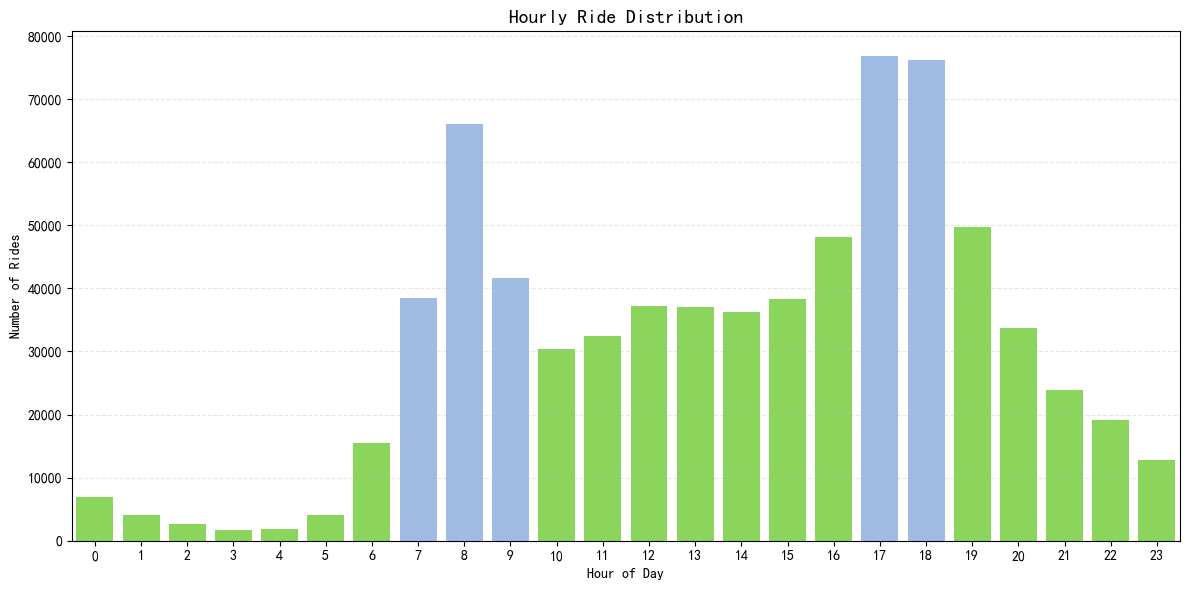

In [51]:


# Aggregate hourly rides
hourly_rides = data.groupby('hour').size().reset_index(name='ride_count')

plt.figure(figsize=(12,6))

sns.barplot(
    data=hourly_rides,
    x='hour',
    y='ride_count',
    palette=["#87E949" if h not in [7,8,9,17,18] else "#94b9f0" 
             for h in hourly_rides['hour']]
    # palette='Blues_d'
)

plt.title("Hourly Ride Distribution", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# 5️. Station Flow Analysis

This section analyzes station-level mobility patterns to understand:

- High-frequency origin-destination routes
- Key departure hubs
- Net inflow and outflow dynamics

The goal is to support operational decisions such as bike redistribution and capacity optimization.


### Popular Routes (Top OD Pairs)

Identify the most frequent origin-destination (OD) pairs to reveal dominant travel corridors.
This helps prioritize redistribution and capacity planning on high-demand routes.


In [52]:
# Count trips for each origin-destination pair
station_flows = (
    data.groupby(['Start station', 'End station'])
        .size()
        .reset_index(name='ride_count')
        .sort_values('ride_count', ascending=False)
)

# Top 10 OD pairs
top_routes = station_flows.head(10)
top_routes


,Start station,End station,ride_count
89035,"Hyde Park Corner, Hyde Park","Albert Gate, Hyde Park",462
3070,"Albert Gate, Hyde Park","Hyde Park Corner, Hyde Park",429
18521,"Black Lion Gate, Kensington Gardens","Hyde Park Corner, Hyde Park",331
89423,"Hyde Park Corner, Hyde Park","Triangle Car Park, Hyde Park",330
1292,"Ackroyd Drive, Bow","Maplin Street, Mile End",323
123385,"Park Lane , Hyde Park","Hyde Park Corner, Hyde Park",302
18583,"Black Lion Gate, Kensington Gardens","Palace Gate, Kensington Gardens",297
105815,"Maplin Street, Mile End","Ackroyd Drive, Bow",269
169144,"Triangle Car Park, Hyde Park","Hyde Park Corner, Hyde Park",267
121653,"Palace Gate, Kensington Gardens","Black Lion Gate, Kensington Gardens",259


This section presents the 10 most popular routes. The data indicates that these popular routes are mostly concentrated near parks and tourist attractions, which may be related to the travel needs of tourists and residents.

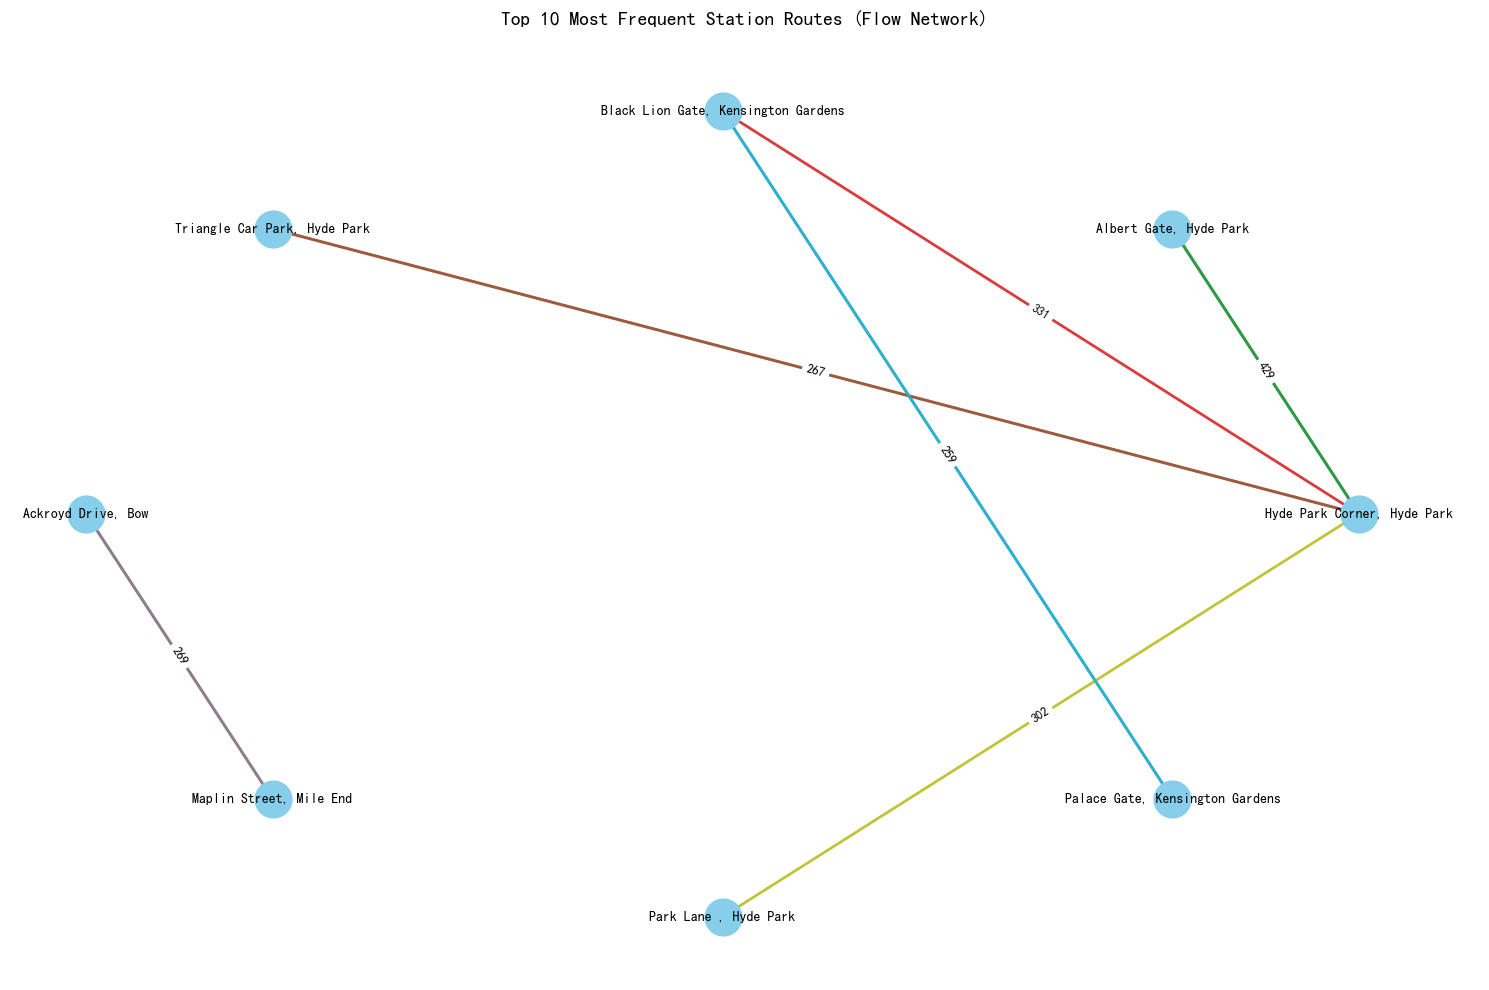

In [53]:


# 1) Build directed graph (use DiGraph, but draw edges without arrows)
G = nx.DiGraph()

for _, row in top_routes.iterrows():  # top 10 routes
    origin = row['Start station']
    destination = row['End station']
    count = row['ride_count']
    G.add_edge(origin, destination, weight=count)

plt.figure(figsize=(15,10))

# 2) Circular layout (to match your target style)
pos = nx.circular_layout(G)

# 3) Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# 4) Draw edges with multi-colors (stable order, not random each run)
color_pool = list(mcolors.TABLEAU_COLORS.values())  # clean palette
edges = list(G.edges(data=True))

for i, (u, v, d) in enumerate(edges):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        arrowstyle='-',          # <- no arrow, line style
        arrowsize=10,
        edge_color=color_pool[i % len(color_pool)],
        width=2,
        alpha=0.9
    )

# 5) Edge labels (ride counts)
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Top 10 Most Frequent Station Routes (Flow Network)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


### Top 10 High-Volume Bike Routes – Key Insights

- Most high-frequency routes are concentrated around **Hyde Park and Kensington Gardens**, indicating a strong localized mobility cluster.
- **Hyde Park Corner** acts as a central hub, connecting multiple high-volume routes.
- Strong bidirectional flows (e.g., Hyde Park ↔ Kensington Gardens) suggest recurring commuter or leisure traffic patterns.
- Peripheral routes (e.g., Mile End ↔ Bow) show isolated but still significant localized demand.

Overall, demand is **clustered rather than evenly distributed**, implying that bike redistribution and capacity planning should prioritize key hub areas instead of uniform allocation across all stations.


## Start Station Analysis

Measure average daily departures per station to identify key origin hubs.

In [54]:
# Daily departures per station
daily_start_rides = (
    data.groupby(['Start station', 'date'])
        .size()
        .reset_index(name='start_ride_count')
)

# Average daily departures per station
avg_daily_start_rides = (
    daily_start_rides.groupby('Start station')['start_ride_count']
        .mean()
        .reset_index(name='avg_daily_start_rides')
        .sort_values('avg_daily_start_rides', ascending=False)
)

avg_daily_start_rides.head(10)


,Start station,avg_daily_start_rides
368,"Hyde Park Corner, Hyde Park",143.483871
759,"Waterloo Station 3, Waterloo",133.483871
793,"Wormwood Street, Liverpool Street",123.935484
757,"Waterloo Station 1, Waterloo",107.838710
74,"Black Lion Gate, Kensington Gardens",99.387097
106,"Brushfield Street, Liverpool Street",95.419355
14,"Albert Gate, Hyde Park",94.064516
357,"Hop Exchange, The Borough",93.161290
209,"Duke Street Hill, London Bridge",91.000000
67,"Bethnal Green Road, Shoreditch",90.870968


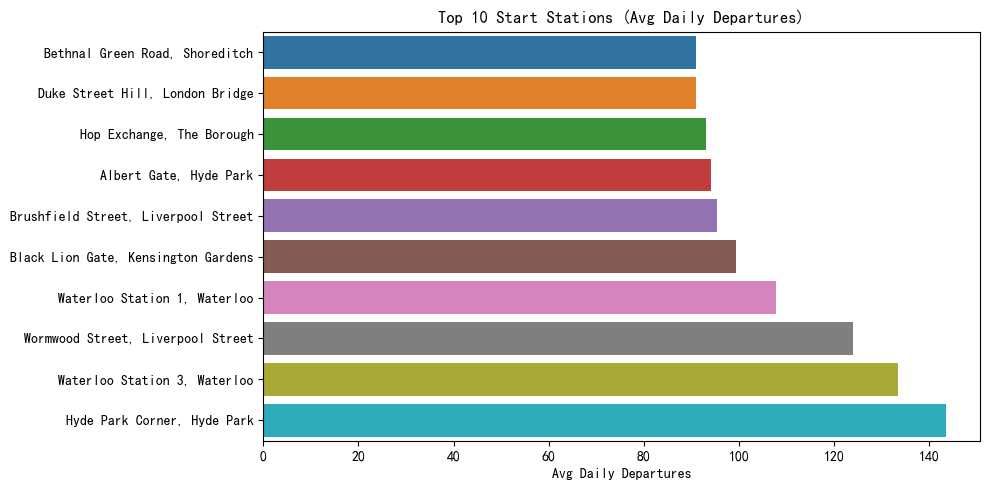

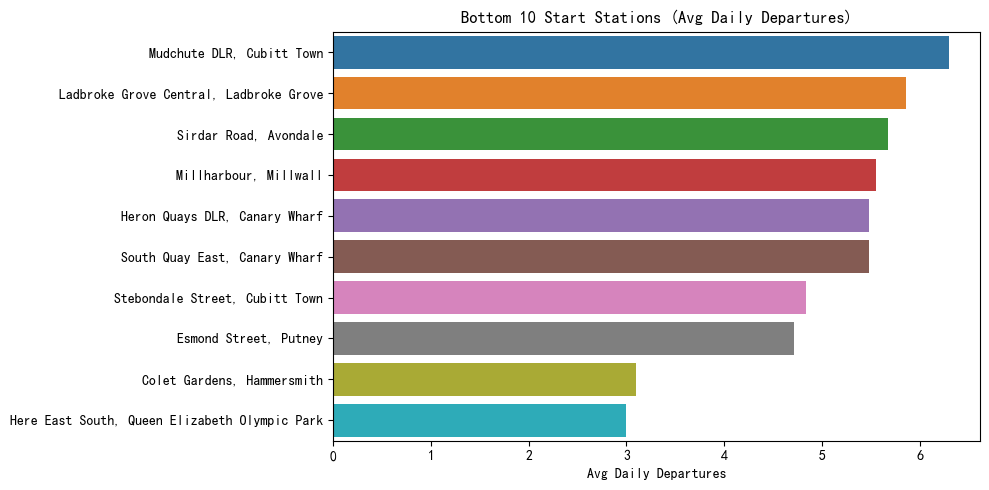

In [55]:


top10_start = avg_daily_start_rides.head(10).sort_values('avg_daily_start_rides', ascending=True)
bottom10_start = avg_daily_start_rides.tail(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top10_start, x='avg_daily_start_rides', y='Start station')
plt.title("Top 10 Start Stations (Avg Daily Departures)")
plt.xlabel("Avg Daily Departures")
plt.ylabel("")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10_start, x='avg_daily_start_rides', y='Start station')
plt.title("Bottom 10 Start Stations (Avg Daily Departures)")
plt.xlabel("Avg Daily Departures")
plt.ylabel("")
plt.tight_layout()
plt.show()


### Start Station Analysis – Key Insights

- **Hyde Park Corner** is the most active departure hub (~143 avg daily rides).
- Multiple stations around **Waterloo** and **Hyde Park / Kensington Gardens** also rank highly.
- Demand is highly concentrated: a small group of stations accounts for a disproportionate share of outbound trips.
- Top stations are located near transport hubs, business districts, and tourist areas.

This pattern indicates strong commuter and mixed-use (commute + leisure) demand concentrated in central London.

### Operational Implications

- High-departure stations require increased morning bike availability.
- Proactive redistribution should prioritize Hyde Park Corner and Waterloo cluster.
- These stations are likely peak-sensitive and require dynamic rebalancing strategies.

The data supports a hub-centric fleet management model rather than uniform station-level allocation.


## Net Flow Analysis

Net Flow = Average Daily Departures − Average Daily Arrivals

- Positive → Net bike outflow (needs replenishment)
- Negative → Net bike inflow (needs redistribution)

In [56]:
# Daily arrivals per station
daily_end_rides = (
    data.groupby(['End station', 'date'])
        .size()
        .reset_index(name='end_ride_count')
)

# Average daily arrivals per station
avg_daily_end_rides = (
    daily_end_rides.groupby('End station')['end_ride_count']
        .mean()
        .reset_index(name='avg_daily_end_rides')
        .rename(columns={'End station': 'station'})
)

# Align station naming for merge
avg_daily_start_rides_renamed = (
    avg_daily_start_rides.rename(columns={'Start station': 'station'})
)

# Net flow
station_net_flow = (
    avg_daily_start_rides_renamed
        .merge(avg_daily_end_rides, on='station', how='outer')
        .fillna(0)
)

station_net_flow['net_flow'] = (
    station_net_flow['avg_daily_start_rides'] - station_net_flow['avg_daily_end_rides']
)

station_net_flow.sort_values('net_flow', ascending=False).head(10)


,station,avg_daily_start_rides,avg_daily_end_rides,net_flow
18,"Waterloo Station 2, Waterloo",80.870968,38.709677,42.161290
457,"Knightsbridge, Hyde Park",23.870968,6.838710,17.032258
37,"Queen Street 2, Bank",64.032258,52.032258,12.000000
89,"Boston Place, Marylebone",48.354839,38.645161,9.709677
26,"London Street, Paddington",69.838710,60.580645,9.258065
192,"Lancaster Gate , Bayswater",37.096774,27.838710,9.258065
94,"Macclesfield Rd, St Lukes",47.741935,38.548387,9.193548
51,"Bayswater Road, Hyde Park",58.419355,50.032258,8.387097
552,"Cloudesley Road, Angel",20.129032,12.161290,7.967742
173,"Graham Street, Angel",38.290323,30.548387,7.741935


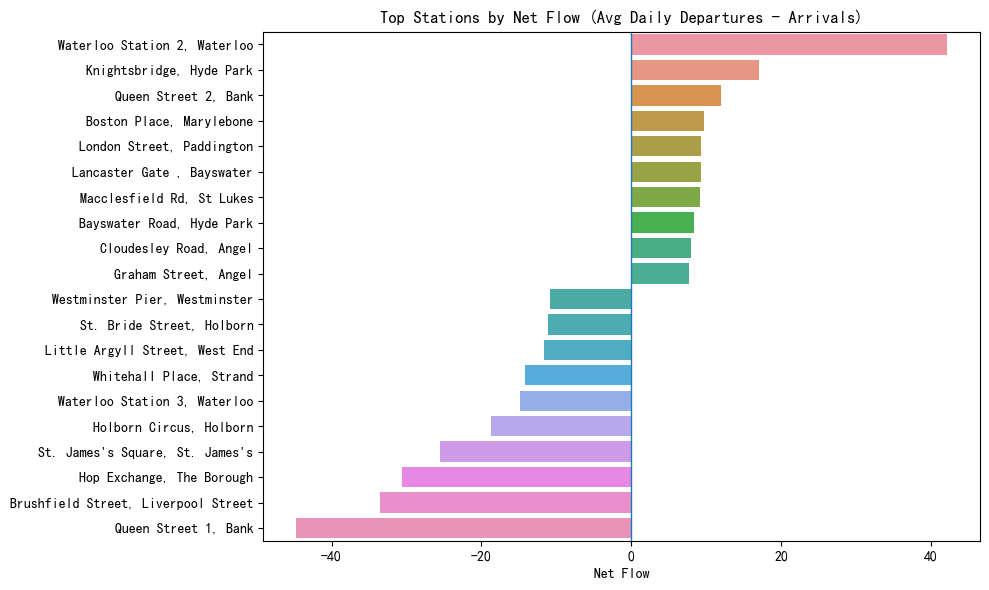

In [57]:
top10_outflow = station_net_flow.nlargest(10, 'net_flow')
top10_inflow = station_net_flow.nsmallest(10, 'net_flow')

combined = pd.concat([top10_outflow, top10_inflow], axis=0)

combined = combined.sort_values('net_flow', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=combined, x='net_flow', y='station')

plt.axvline(0, linewidth=1)
plt.title("Top Stations by Net Flow (Avg Daily Departures - Arrivals)")
plt.xlabel("Net Flow")
plt.ylabel("")
plt.tight_layout()
plt.show()


### Net Flow Analysis – Key Insights

- **Waterloo Station 2** shows the strongest positive net flow, indicating it functions as a major departure hub.
- Several central business and transit locations (e.g., Knightsbridge, Bank, Marylebone) also exhibit net outflow patterns.
- Stations such as **Queen Street 1 (Bank)** and **Brushfield Street (Liverpool Street)** show strong negative net flow, meaning more bikes arrive than depart.
- The imbalance suggests directional commuting patterns between business districts and surrounding areas.

Overall, the system exhibits clear spatial imbalance, with certain hubs consistently exporting bikes while others accumulate them.

### Operational Implications

- High positive net-flow stations require proactive bike replenishment during peak hours.
- High negative net-flow stations may face dock capacity constraints.
- Redistribution strategies should prioritize morning relocation from inflow-heavy stations to outflow-heavy hubs.

Net flow metrics provide direct guidance for dynamic rebalancing operations.


# 6. Station Segmentation with K-Means

### Goal
Segment stations into behavioral groups based on:
- average daily departures
- average daily arrivals
- net flow (departures - arrivals)
- average ride duration

This supports differentiated operational strategies (capacity allocation & rebalancing).


## Step 1 — Build station-level features (station_stats)

In [58]:
# --- Prepare station-level daily departures ---
daily_start_rides = (
    data.groupby(['Start station', 'date'])
        .size()
        .reset_index(name='start_ride_count')
)

avg_daily_start = (
    daily_start_rides.groupby('Start station')['start_ride_count']
        .mean()
        .reset_index(name='avg_daily_start_rides')
        .rename(columns={'Start station': 'station'})
)

# --- Prepare station-level daily arrivals ---
daily_end_rides = (
    data.groupby(['End station', 'date'])
        .size()
        .reset_index(name='end_ride_count')
)

avg_daily_end = (
    daily_end_rides.groupby('End station')['end_ride_count']
        .mean()
        .reset_index(name='avg_daily_end_rides')
        .rename(columns={'End station': 'station'})
)

# --- Merge start & end features ---
station_stats = (
    avg_daily_start.merge(avg_daily_end, on='station', how='outer')
    .fillna(0)
)

# Net flow feature
station_stats['net_flow'] = (
    station_stats['avg_daily_start_rides'] - station_stats['avg_daily_end_rides']
)

# --- Average ride duration per station (based on trip start station) ---
avg_duration = (
    data.groupby('Start station')['Total duration (s)']
        .mean()
        .reset_index(name='avg_ride_duration_s')
        .rename(columns={'Start station': 'station'})
)

station_stats = station_stats.merge(avg_duration, on='station', how='left').fillna(0)

station_stats.head()



,station,avg_daily_start_rides,avg_daily_end_rides,net_flow,avg_ride_duration_s
0,"Abbey Orchard Street, Westminster",36.645161,41.193548,-4.548387,1169.143111
1,"Abbotsbury Road, Holland Park",10.354839,9.032258,1.322581,1048.285648
2,"Aberdeen Place, St. John's Wood",22.935484,18.193548,4.741935,1015.299523
3,"Aberfeldy Street, Poplar",9.741935,10.000000,-0.258065,1341.007192
4,"Abingdon Green, Westminster",25.516129,33.387097,-7.870968,1234.227927


## Step 2 — Feature selection + Standardization

In [59]:


feature_cols = [
    'avg_daily_start_rides',
    'avg_daily_end_rides',
    'net_flow',
    'avg_ride_duration_s'
]

X = station_stats[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [60]:
X_scaled

array([[ 0.39184073,  0.60675648, -1.12209087,  0.33537418],
       [-1.10714169, -1.10411727,  0.33103748, -0.15090931],
       [-0.38983722, -0.61676708,  1.17736498, -0.28363267],
       ...,
       [-0.99494792, -0.95482338,  0.12344772,  0.2556862 ],
       [ 0.31827104,  0.27213222,  0.1154635 , -0.71499576],
       [-0.36040935, -0.32504337, -0.05220516,  0.03359411]])

**Why scaling matters**
K-Means is distance-based. Scaling ensures no single feature dominates due to magnitude differences.


## Step 3 — Choose the best K (Elbow + Silhouette)

In [61]:


inertia = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=15, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))


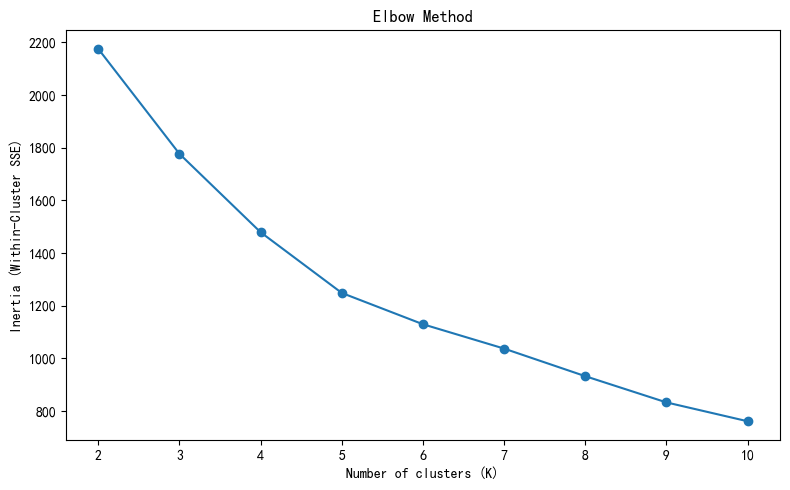

In [62]:


# Elbow curve
plt.figure(figsize=(8,5))
plt.plot(list(k_values), inertia, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method")
plt.tight_layout()
plt.show()


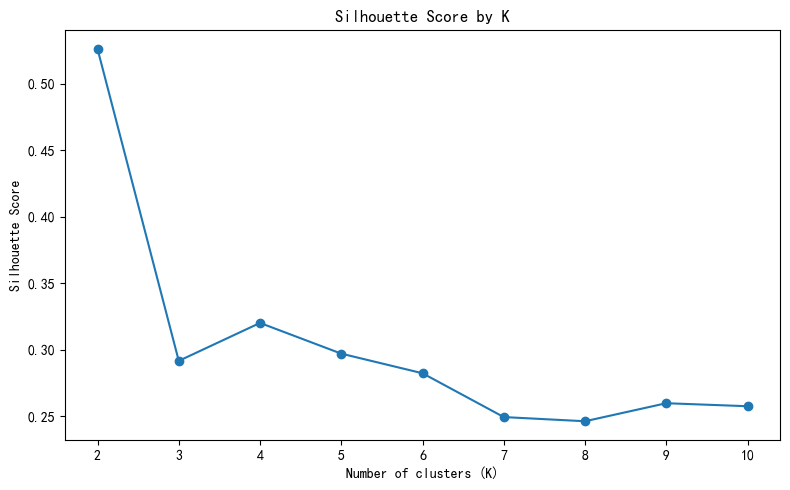

In [63]:
# Silhouette curve
plt.figure(figsize=(8,5))
plt.plot(list(k_values), sil_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K")
plt.tight_layout()
plt.show()


### 1️. Elbow Method (Inertia / SSE)

- Inertia decreases sharply from **K=2 to K=4**.
- After **K=5 or K=6**, the curve begins to flatten.
- The marginal reduction in SSE becomes smaller beyond **K=5**.

Interpretation:  
The “elbow” appears around **K = 5 or K = 6**, indicating diminishing returns in cluster compactness after that point.

---

### 2️. Silhouette Score

- The highest silhouette score occurs at **K=2 (~0.52)**.
- However, K=2 may be overly simplistic for operational segmentation.
- A secondary local maximum appears around **K=4 (~0.32)**.
- After K=5, silhouette scores gradually decline.

Interpretation:  
While K=2 provides the strongest mathematical separation, it likely underfits business complexity.  
**K=5 offers a good balance between separation quality and segmentation granularity.**


## Step 4 — Fit K-Means (K=5) and assign clusters

In [64]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=15, n_init=10)
station_stats['cluster'] = kmeans.fit_predict(X_scaled)

station_stats.head()


,station,avg_daily_start_rides,avg_daily_end_rides,net_flow,avg_ride_duration_s,cluster
0,"Abbey Orchard Street, Westminster",36.645161,41.193548,-4.548387,1169.143111,2
1,"Abbotsbury Road, Holland Park",10.354839,9.032258,1.322581,1048.285648,0
2,"Aberdeen Place, St. John's Wood",22.935484,18.193548,4.741935,1015.299523,0
3,"Aberfeldy Street, Poplar",9.741935,10.000000,-0.258065,1341.007192,3
4,"Abingdon Green, Westminster",25.516129,33.387097,-7.870968,1234.227927,3


## Step 5 — PCA visualization (2D)

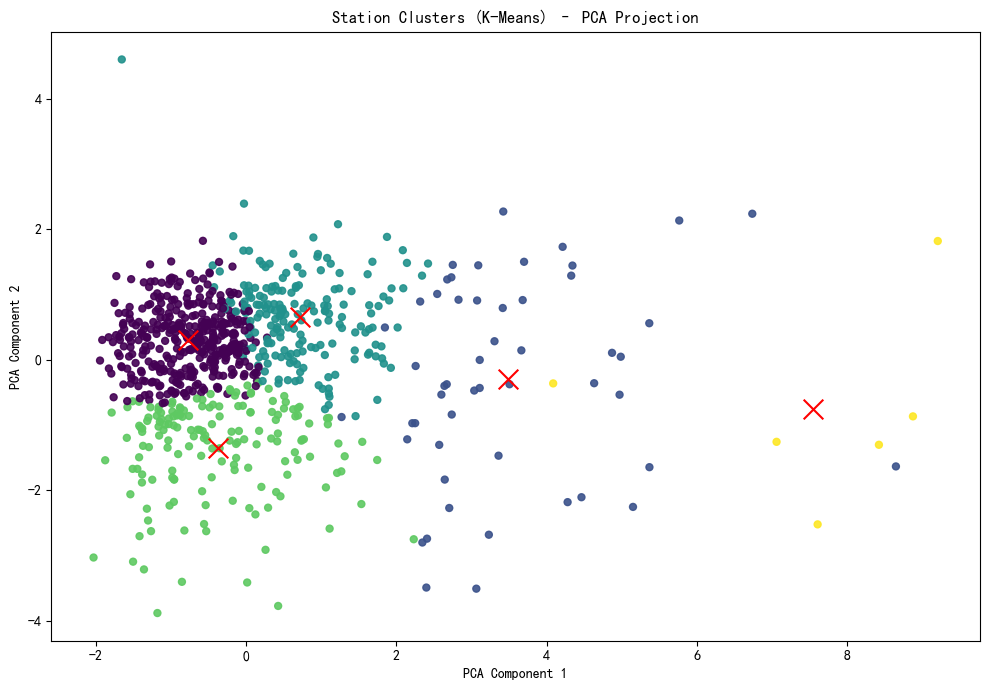

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=15)
X_pca = pca.fit_transform(X_scaled)

centers_scaled = kmeans.cluster_centers_
centers_pca = pca.transform(centers_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=station_stats['cluster'], cmap='viridis', s=25, alpha=0.9)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='red', s=200, marker='x')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Station Clusters (K-Means) – PCA Projection")
plt.tight_layout()
plt.show()


##  Conclusion

- Clusters are reasonably well separated.
- High-demand hubs are clearly distinguishable from regular stations.
- The chosen K provides meaningful and operationally interpretable segmentation.


## Step 6 — Cluster profile summary (mean / std)

In [66]:
cluster_summary = (
    station_stats.groupby('cluster')[feature_cols]
        .agg(['mean', 'std', 'count'])
)

# Flatten multi-index columns for readability
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary = cluster_summary.reset_index()

cluster_summary


,cluster,avg_daily_start_rides_mean,avg_daily_start_rides_std,avg_daily_start_rides_count,avg_daily_end_rides_mean,avg_daily_end_rides_std,avg_daily_end_rides_count,net_flow_mean,net_flow_std,net_flow_count,avg_ride_duration_s_mean,avg_ride_duration_s_std,avg_ride_duration_s_count
0,0,21.155385,6.466904,389,20.385893,6.493487,389,0.769492,1.920567,389,972.633647,113.485676,389
1,1,72.277295,18.312221,52,74.782258,18.183362,52,-2.504963,4.370895,52,1337.728482,396.225047,52
2,2,41.572427,8.084037,187,40.962100,7.720996,187,0.610327,4.234289,187,980.349320,138.112005,187
3,3,21.315610,10.009092,166,22.080775,10.829452,166,-0.765165,2.809463,166,1393.723588,200.542133,166
4,4,86.317204,28.803200,6,114.333333,25.604132,6,-28.016129,10.801198,6,1005.576158,132.379060,6


## Step 7 — Distribution comparison (boxplots)

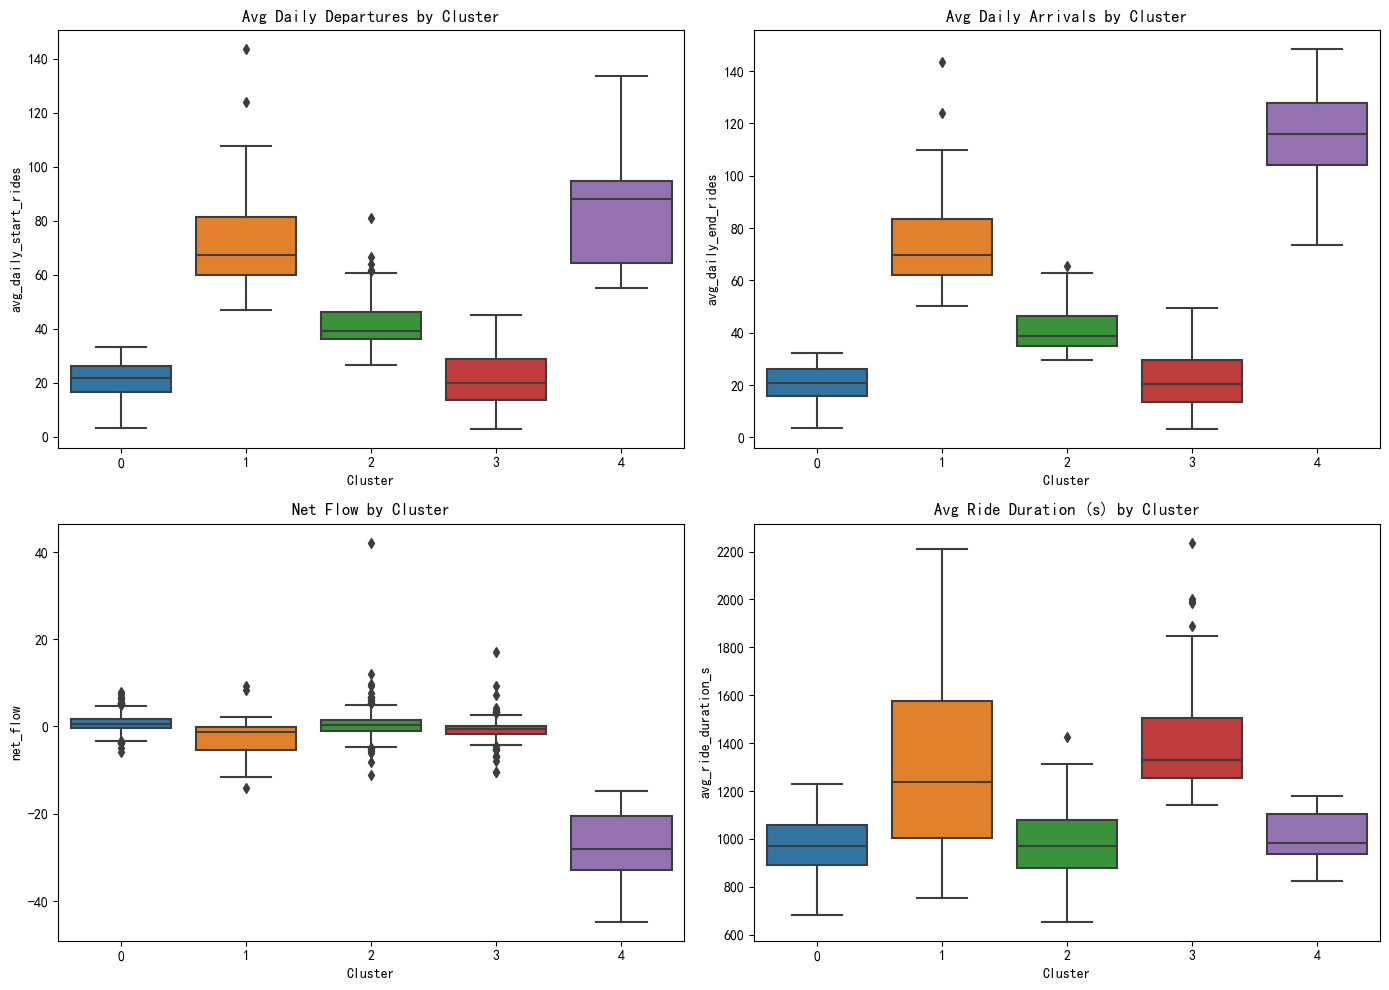

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

plots = [
    ('avg_daily_start_rides', 'Avg Daily Departures by Cluster'),
    ('avg_daily_end_rides', 'Avg Daily Arrivals by Cluster'),
    ('net_flow', 'Net Flow by Cluster'),
    ('avg_ride_duration_s', 'Avg Ride Duration (s) by Cluster')
]

for ax, (col, title) in zip(axes.flatten(), plots):
    sns.boxplot(x='cluster', y=col, data=station_stats, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


## Resource Optimization Strategy by Cluster (K = 5)

Based on the clustering results (demand intensity, net flow structure, and ride duration), each station group represents a different operational role in the network. Below are targeted optimization strategies for each cluster.

---

### 🔵 Cluster 4 — High-Demand Destination Hubs  
**Characteristics**
- Highest departures & arrivals
- Strong negative net flow (inflow-dominant)
- High and stable demand

### Operational Role
Core business/commercial centers or transport hubs.

### Resource Optimization Strategy
1. **Increase Dock Capacity**
   - Expand docking stations where feasible.
   - Prevent congestion during peak hours.

2. **Aggressive Rebalancing (Outbound Redistribution)**
   - Schedule morning and evening rebalancing.
   - Use predictive models to pre-allocate bikes.

3. **Dynamic Bike Allocation**
   - Prioritize these hubs during fleet redistribution.
   - Maintain higher minimum bike threshold.

4. **Peak Hour Staffing**
   - Monitor system health more frequently.

Goal: Avoid dock saturation and ensure availability reliability.

---

### 🟠 Cluster 1 — Busy Mixed-Use Stations  
**Characteristics**
- High demand
- Moderate negative net flow
- High variability

### Operational Role
High-traffic urban stations with bidirectional flow.

### Resource Optimization Strategy
1. **Flexible Rebalancing**
   - Adjust redistribution based on time-of-day patterns.
   - Apply hourly predictive forecasting.

2. **Smart Dock Allocation**
   - Maintain balanced dock-to-bike ratio.

3. **Real-Time Monitoring**
   - Implement alert system for sudden demand spikes.

Goal: Maintain operational balance under fluctuating demand.

---

### 🟢 Cluster 2 — Balanced Commuter Stations  
**Characteristics**
- Moderate demand
- Net flow ≈ 0 (balanced)
- Medium ride duration

### Operational Role
Residential-to-work transition nodes.

### Resource Optimization Strategy
1. **Minimal Intervention**
   - Low rebalancing priority.
   - Allow natural self-balancing.

2. **Optimize Fleet Utilization**
   - Use these as temporary buffering stations.

3. **Demand Smoothing**
   - Monitor seasonal changes rather than hourly.

Goal: Reduce operational costs by limiting unnecessary redistribution.

---

### 🔴 Cluster 3 — Low Demand, Long Duration Stations  
**Characteristics**
- Low ride volume
- Long ride duration
- Slight net inflow

### Operational Role
Leisure/tourist areas or peripheral zones.

### Resource Optimization Strategy
1. **Smaller Dock Capacity**
   - Avoid over-investment in infrastructure.

2. **Scheduled Rebalancing (Low Frequency)**
   - Redistribute during off-peak hours.

3. **Tourism-Oriented Planning**
   - Increase availability during weekends/holidays.

4. **Promotional Strategy**
   - Encourage off-peak usage.

Goal: Match supply with sporadic but longer usage patterns.

---

### 🟣 Cluster 0 — Low-to-Medium Residential Stations  
**Characteristics**
- Low demand
- Balanced net flow
- Shorter ride duration

### Operational Role
Neighborhood-level origin stations.

### Resource Optimization Strategy
1. **Maintain Moderate Supply**
   - Ensure morning availability.

2. **Morning Replenishment**
   - Focus redistribution before commuting hours.

3. **Cost-Efficient Operations**
   - Lower monitoring frequency.

Goal: Support daily commuting without over-allocation.

---

### System-Level Optimization Recommendations

### 1️. Demand-Based Fleet Allocation
Allocate bikes proportionally:
- 35–40% → Cluster 4
- 25–30% → Cluster 1
- 15–20% → Cluster 2
- 10–15% → Cluster 0
- 5–10% → Cluster 3

### 2️. Predictive Rebalancing Model
Combine:
- Time-of-day patterns
- Net flow trend
- Cluster classification

### 3️. Dynamic Dock Expansion Planning
Prioritize:
Cluster 4 → Cluster 1 → Cluster 2

### 4️. Cost Optimization
Reduce redistribution frequency for balanced clusters (0 & 2).

---

### Final Strategic Insight

The clustering enables **differentiated operational management**:

- Not all stations need equal resources.
- High-demand inflow hubs require infrastructure investment.
- Balanced commuter stations require efficiency.
- Leisure zones require adaptive, low-cost management.

This segmentation supports:

- Smarter capital allocation  
- Reduced redistribution cost  
- Higher service reliability  
- Improved fleet utilization  

Data-driven clustering translates directly into actionable urban mobility strategy.


# 7. One-Way ANOVA (F-Test)

Interpretation of F-Statistic and p-Value (ANOVA)

F-statistic:
The F-statistic measures the ratio of between-group variance to within-group variance.
A larger F value indicates that differences between group means are relatively large compared to variability within groups, increasing the likelihood of rejecting the null hypothesis.

p-value:
The p-value determines whether the null hypothesis (all group means are equal) should be rejected.
If p < 0.05 (given a 5% significance level), the differences between groups are statistically significant, and the null hypothesis is rejected.
If p ≥ 0.05, there is insufficient evidence to conclude that group means differ significantly.

In [ ]:
# One-way ANOVA function
def anova_test(groups):
    anova_result = stats.f_oneway(*groups)
    return anova_result.statistic, anova_result.pvalue


results = []

# Hour
hourly_groups = [
    data[data['hour'] == hour].groupby('Start date').size()
    for hour in range(24)
]
stat, pval = anova_test(hourly_groups)
results.append(['Hour', stat, pval])

# Weekday
weekday_groups = [
    data[data['weekday'] == day].groupby('Start date').size()
    for day in data['weekday'].unique()
]
stat, pval = anova_test(weekday_groups)
results.append(['Weekday', stat, pval])

# Station  
station_groups = [
    data[data['Start station'] == station].groupby('Start date').size()
    for station in data['Start station'].unique()
]
stat, pval = anova_test(station_groups)
results.append(['Station', stat, pval])

# Bike Model
bike_model_groups = [
    data[data['Bike model'] == model].groupby('Start date').size()
    for model in data['Bike model'].unique()
]
stat, pval = anova_test(bike_model_groups)
results.append(['Bike Model', stat, pval])

# Output results
results_df = pd.DataFrame(results, columns=['Feature', 'F', 'p_value'])

# Keep 3 decimal places
results_df['F'] = results_df['F'].round(3)
results_df['p_value'] = results_df['p_value'].round(3)

print(results_df)


      Feature          F  p_value
0        Hour   2873.113      0.0
1     Weekday    329.964      0.0
2     Station     31.507      0.0
3  Bike Model  29889.002      0.0


### ANOVA Conclusion

All features (hour, weekday, station, bike model) have p < 0.05, indicating statistically significant differences in ride volume across groups.

This means ride demand is significantly influenced by:

- Time of day

- Day of week

- Station location

- Bike model

### Business Recommendations

- Time-based allocation: Increase supply during peak hours; reduce idle bikes off-peak.

- Weekday vs weekend strategy: Adjust fleet mix for commuting vs leisure demand.

- Station-level optimization: Rebalance bikes between residential and business areas.

- Bike model management: Expand high-demand models; optimize low-performing models.



# 8. Project Summary

This project provides a comprehensive analysis of London bike-sharing data, including data cleaning, feature engineering, demand pattern analysis, station flow analysis, K-Means clustering (800 stations grouped into 5 clusters), and ANOVA testing to identify key demand drivers.

---

## 1. System Overview

- ~735,000 valid trips after cleaning  
- 800 unique stations  
- Median trip duration: ~817 seconds (~13.6 minutes)  
- Mean trip duration: ~1,094 seconds (~18 minutes)  
- Trip duration distribution is right-skewed  

Overall, the system is high-volume and commuter-oriented, with predominantly short urban trips.

---

## 2. Demand Patterns

- Clear **bimodal daily distribution**
  - Morning peak: 7–9 AM  
  - Evening peak: 5–6 PM  
- Lowest demand: 12–5 AM  
- Higher weekday demand (especially Tuesday–Thursday)

These patterns strongly indicate commuter-driven mobility behavior.

---

## 3. High-Volume Routes & Spatial Concentration

- Demand is highly concentrated around **Hyde Park and Kensington Gardens**
- Hyde Park Corner functions as a central mobility hub
- Popular routes are geographically clustered rather than evenly distributed

This suggests resource allocation should prioritize key hub areas.

---

## 4. Net Flow Imbalance

- Some stations act as net departure hubs  
- Others accumulate arrivals during peak hours  

Operational implications:
- High outflow stations → increase bike replenishment  
- High inflow stations → expand docking capacity and accelerate redistribution  

---

## 5. Station Clustering (K = 5)

Stations were segmented using:
- Average daily departures  
- Average daily arrivals  
- Net flow  
- Average ride duration  

Cluster characteristics:
- **Low-demand stations** → optimize capacity, reduce idle bikes  
- **Balanced stations** → maintain current configuration  
- **Inflow-heavy stations** → strengthen redistribution strategy  
- **High-demand hubs** → prioritize supply and real-time dispatching  

PCA visualization confirms clear separation of high-demand clusters.

---

## 6. ANOVA Results

One-way ANOVA shows that the following features significantly impact ride volume (p < 0.05):

- Hour  
- Weekday  
- Station  
- Bike Model  

Ride demand varies significantly across time, location, and bike type.

---

# Overall Conclusion

London’s bike-sharing system demonstrates:

- Strong commuter-driven temporal dynamics  
- Clear spatial clustering around central hubs  
- Significant station-level demand imbalance  
- Statistically significant variation across key demand drivers  

Operational optimization should adopt **cluster-based resource allocation and peak-time dynamic redistribution**, rather than uniform bike distribution across all stations.


# 9.总结

In [ ]:
本项目对伦敦共享单车数据进行了全面分析，涵盖了数据清洗、特征工程（构建新特征）、骑行高峰期分析、站点流量分析，以及通过聚类分析将800个站点划分为5类，并对每一类站点提出建议，最后通过方差分析探讨了影响共享单车流量的因素。得出的主要结论如下：

站点使用情况：

共有800个站点，最常用的起始站为Hyde Park Corner, Hyde Park，最常用的终点站为Waterloo Station 3, Waterloo。
每日骑行次数：

高峰日的骑行次数达到30132次（2023年8月9日），周三为骑行最高峰，总计136595次。
骑行时间分析：

最常见的骑行时间为7分48秒，共658次。
平均骑行时间为1097.73秒（约18.3分钟），标准差为1210.34秒，最短为60秒（1分钟），最长为28770秒（约8小时）。
自行车型号：

使用的自行车分为CLASSIC和ELECTRIC两种，其中CLASSIC的使用次数最多，共计677,259次。
骑行高峰时段：

每天的骑行高峰时段为下午3点至6点。
骑行时长波动：

大多数情况下，骑行的平均时长大致相同，但在某些日期骑行次数减少，总时长却增加，这表明这些日期的平均骑行时长有所不同。
8月的骑行总时长和次数显著波动，表明共享单车使用量随日期变化，与天气、节假日等因素有关。8月5日为显著低谷，与前后两天形成鲜明对比。
周骑行模式：

周二、周三、周四为骑行高峰期，无论骑行次数还是总时长都远高于其他时间；周六为低谷期，骑行次数和总时长都较短；周日骑行次数不多，但总时长较长，表明平均骑行时长高于周一和周五。
热门线路和站点：

热门线路多集中在公园和旅游景点附近，如Hyde Park Corner, Hyde Park为主要枢纽站点。
Hyde Park、Waterloo和Liverpool Street周边为骑行活动集中地。运营者应在这些区域增加更多的自行车和停车设施，以满足高需求。
冷门站点分析：

冷门站点主要位于奥林匹克公园、汉默史密斯、帕特尼、坎纳里码头和拉德布鲁克格罗夫等区域。这些区域可能因地理位置或用途导致骑行需求较低。运营者可以考虑在这些低频使用站点减少资源配置，并通过推广活动提升使用率。
高低净流量站点：

高净流量站点需增加自行车供应，低净流量站点需增加停车设施，以接纳更多到达的自行车。
聚类分析结果：

聚类 0：使用频率较低，建议优化自行车资源配置，减少闲置车辆，并加强推广吸引用户。
聚类 1：终点站使用更多，建议增加自行车停放设施，避免高峰期积压，并加强车辆调度。
聚类 2：使用频率中等且均衡，建议保持现有资源配置，并持续优化服务质量。
聚类 3：终点站使用更多，建议增加自行车停放设施，避免高峰期积压，并加强车辆调度。
聚类 4：终点站使用显著更多，需大幅增加自行车停放设施，避免车辆积压，并强化车辆调度和管理。
影响因素分析：

不同时间段、星期几、站点和自行车型号的骑行次数存在显著差异。运营优化时，应重点考虑这些特征对骑行需求的影响。